In [1]:
# ! pip install --upgrade pip numpy pandas networkx chardet stellargraph scikit-learn gensim matplotlib numba pynndescent umap-learn torch torch-geometric ogb
# ! python -c "import ogb; print(ogb.__version__)"

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import umap
import random
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from ogb.linkproppred import PygLinkPropPredDataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

# Download and process data, stored in './dataset/ogbl_collab/'
dataset = PygLinkPropPredDataset(name="ogbl-collab", root='dataset/')
data = dataset[0]

/home/xiaot/miniconda3/envs/cs276p/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-17 22:51:28.209294: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 22:51:28.499482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 22:51:29.474309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Te

In [2]:
# Show dataset information
print("Dataset Name:", dataset.name)
print("Number of Nodes:", data.num_nodes)
print("Number of Edges:", data.edge_index.shape[1])
print("Number of Node Features:", data.x.shape[1] if data.x is not None else "None")
print("Number of Edge Features:", data.edge_attr.shape[1] if data.edge_attr is not None else "None")

Dataset Name: ogbl-collab
Number of Nodes: 235868
Number of Edges: 2358104
Number of Node Features: 128
Number of Edge Features: None


In [3]:
# Split edges into train/validation/test sets
split_edge = dataset.get_edge_split()

/home/xiaot/miniconda3/envs/cs276p/lib/python3.8/site-packages/ogb/linkproppred/dataset_pyg.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train = replace_numpy_with_t

In [4]:
# -> NetworkX graph
edge_list = split_edge['train']['edge']
graph = nx.Graph()
graph.add_edges_from(edge_list.tolist())

# NetworkX graph -> StellarGraph
stellargraph = StellarGraph.from_networkx(graph)

In [5]:
# Generate Node2Vec walks
random_walk = BiasedRandomWalk(stellargraph)
walks = random_walk.run(
    nodes=list(stellargraph.nodes()),  # root nodes
    length=10,  # maximum length of a random walk
    n=2,  # number of random walks per root node
    p=1.0,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=1.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)

In [6]:
# Ensure all nodes appear in walks
all_nodes = set(str(node) for node in stellargraph.nodes())
walked_nodes = set(word for walk in walks for word in walk)
missing_nodes = all_nodes - walked_nodes

# Add singleton walks for missing nodes
walks.extend([[str(node)] for node in missing_nodes])

# Train Word2Vec model
word2vec_model = Word2Vec(walks, vector_size=128, window=5, min_count=0, sg=1, workers=4, epochs=10)

# Extract node embeddings
default_embedding = np.zeros(word2vec_model.vector_size)
node_embeddings = {
    str(node): word2vec_model.wv[str(node)] if str(node) in word2vec_model.wv else default_embedding
    for node in stellargraph.nodes()
}
node_emb_values = np.array(list(node_embeddings.values()))

Running PCA...
PCA completed. Reduced to shape: (5000, 50)
Running UMAP...
UMAP(min_dist=0.3, n_jobs=1, random_state=42, verbose=True)
Sun Nov 17 22:56:06 2024 Construct fuzzy simplicial set
Sun Nov 17 22:56:06 2024 Finding Nearest Neighbors
Sun Nov 17 22:56:06 2024 Building RP forest with 9 trees


/home/xiaot/miniconda3/envs/cs276p/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Sun Nov 17 22:56:09 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	Stopping threshold met -- exiting after 7 iterations
Sun Nov 17 22:56:15 2024 Finished Nearest Neighbor Search
Sun Nov 17 22:56:18 2024 Construct embedding


Epochs completed:   5%| ▌          26/500 [00:00]

	completed  0  /  500 epochs


Epochs completed:  14%| █▍         72/500 [00:01]

	completed  50  /  500 epochs


Epochs completed:  23%| ██▎        117/500 [00:01]

	completed  100  /  500 epochs


Epochs completed:  33%| ███▎       163/500 [00:01]

	completed  150  /  500 epochs


Epochs completed:  45%| ████▍      223/500 [00:02]

	completed  200  /  500 epochs


Epochs completed:  54%| █████▍     271/500 [00:02]

	completed  250  /  500 epochs


Epochs completed:  64%| ██████▍    319/500 [00:03]

	completed  300  /  500 epochs


Epochs completed:  73%| ███████▎   367/500 [00:03]

	completed  350  /  500 epochs


Epochs completed:  83%| ████████▎  415/500 [00:04]

	completed  400  /  500 epochs


Epochs completed:  93%| █████████▎ 463/500 [00:04]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:04]


Sun Nov 17 22:56:21 2024 Finished embedding
UMAP completed.


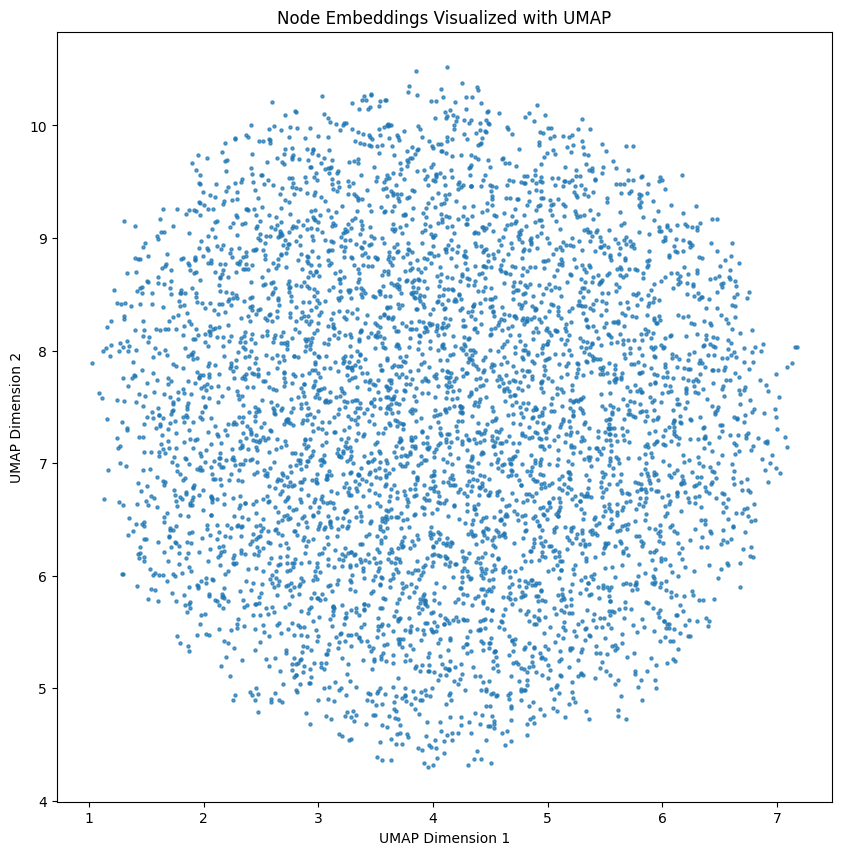

In [ ]:
# Subset the data if it's too large
num_samples = 5000  # Adjust this based on available memory
subset_indices = np.random.choice(node_emb_values.shape[0], size=num_samples, replace=False)
node_emb_subset = node_emb_values[subset_indices]

# Ensure the embeddings are in float32 format
node_emb_subset = node_emb_subset.astype(np.float32)

# Step 1: Reduce dimensionality with PCA first
print("Running PCA...")
pca = PCA(n_components=50, random_state=42)
node_emb_pca = pca.fit_transform(node_emb_subset)
print(f"PCA completed. Reduced to shape: {node_emb_pca.shape}")

# Step 2: Use UMAP on PCA-reduced embeddings
print("Running UMAP...")
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.3, random_state=42, verbose=True)
node_emb_2d = reducer.fit_transform(node_emb_pca)
print("UMAP completed.")

# Step 3: Plot the reduced embeddings
plt.figure(figsize=(10, 10))
plt.scatter(node_emb_2d[:, 0], node_emb_2d[:, 1], s=5, alpha=0.7)
plt.title("Node Embeddings Visualized with UMAP")
plt.show()

In [8]:
# Prepare edge features
def prepare_edge_features_batch(edge_index, embeddings, batch_size=10000):
    edge_features = []
    num_edges = edge_index.shape[0]
    
    for start in range(0, num_edges, batch_size):
        end = min(start + batch_size, num_edges)
        batch = edge_index[start:end]
        features = [np.concatenate([embeddings[str(i)], embeddings[str(j)]]) for i, j in batch]
        edge_features.extend(features)
    
    return np.array(edge_features)

In [9]:
# Negative sampling
def sample_negative_edges(num_nodes, pos_edge_index, num_samples):
    neg_edges = []
    pos_edge_set = set(map(tuple, pos_edge_index.tolist()))
    while len(neg_edges) < num_samples:
        i, j = random.randint(0, num_nodes - 1), random.randint(0, num_nodes - 1)
        if i != j and (i, j) not in pos_edge_set and (j, i) not in pos_edge_set:
            neg_edges.append((i, j))
    return np.array(neg_edges)

In [10]:
# Prepare train/validation/test datasets
train_pos_edges = split_edge['train']['edge'].numpy()

valid_pos_edges = split_edge['valid']['edge'].numpy()
valid_neg_edges = split_edge['valid']['edge_neg'].numpy()

test_pos_edges = split_edge['test']['edge'].numpy()
test_neg_edges = split_edge['test']['edge_neg'].numpy()

In [11]:
# Generate negative edges
train_neg_edges = sample_negative_edges(data.num_nodes, train_pos_edges, len(train_pos_edges))

In [12]:
# Generate edge features
batch_size = 10000  # Adjust this based on available memory

train_pos_edges = train_pos_edges[:10000]
train_neg_edges = train_neg_edges[:10000]

train_pos_features = prepare_edge_features_batch(train_pos_edges, node_embeddings, batch_size)
train_neg_features = prepare_edge_features_batch(train_neg_edges, node_embeddings, batch_size)

valid_pos_features = prepare_edge_features_batch(valid_pos_edges, node_embeddings, batch_size)
valid_neg_features = prepare_edge_features_batch(valid_neg_edges, node_embeddings, batch_size)

test_pos_features = prepare_edge_features_batch(test_pos_edges, node_embeddings, batch_size)
test_neg_features = prepare_edge_features_batch(test_neg_edges, node_embeddings, batch_size)

In [13]:
# Combine positive and negative edges
train_features = np.vstack([train_pos_features, train_neg_features])
train_labels = np.hstack([np.ones(len(train_pos_features)), np.zeros(len(train_neg_features))])

valid_features = np.vstack([valid_pos_features, valid_neg_features])
valid_labels = np.hstack([np.ones(len(valid_pos_features)), np.zeros(len(valid_neg_features))])

test_features = np.vstack([test_pos_features, test_neg_features])
test_labels = np.hstack([np.ones(len(test_pos_features)), np.zeros(len(test_neg_features))])

In [14]:
# Train Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_features, train_labels)

LogisticRegression(max_iter=1000)

In [15]:
# Evaluate on validation and test sets
valid_preds = classifier.predict_proba(valid_features)[:, 1]
valid_auc = roc_auc_score(valid_labels, valid_preds)
print(f"Validation AUC: {valid_auc:.4f}")

test_preds = classifier.predict_proba(test_features)[:, 1]
test_auc = roc_auc_score(test_labels, test_preds)
print(f"Test AUC: {test_auc:.4f}")

Validation AUC: 0.5014
Test AUC: 0.5004


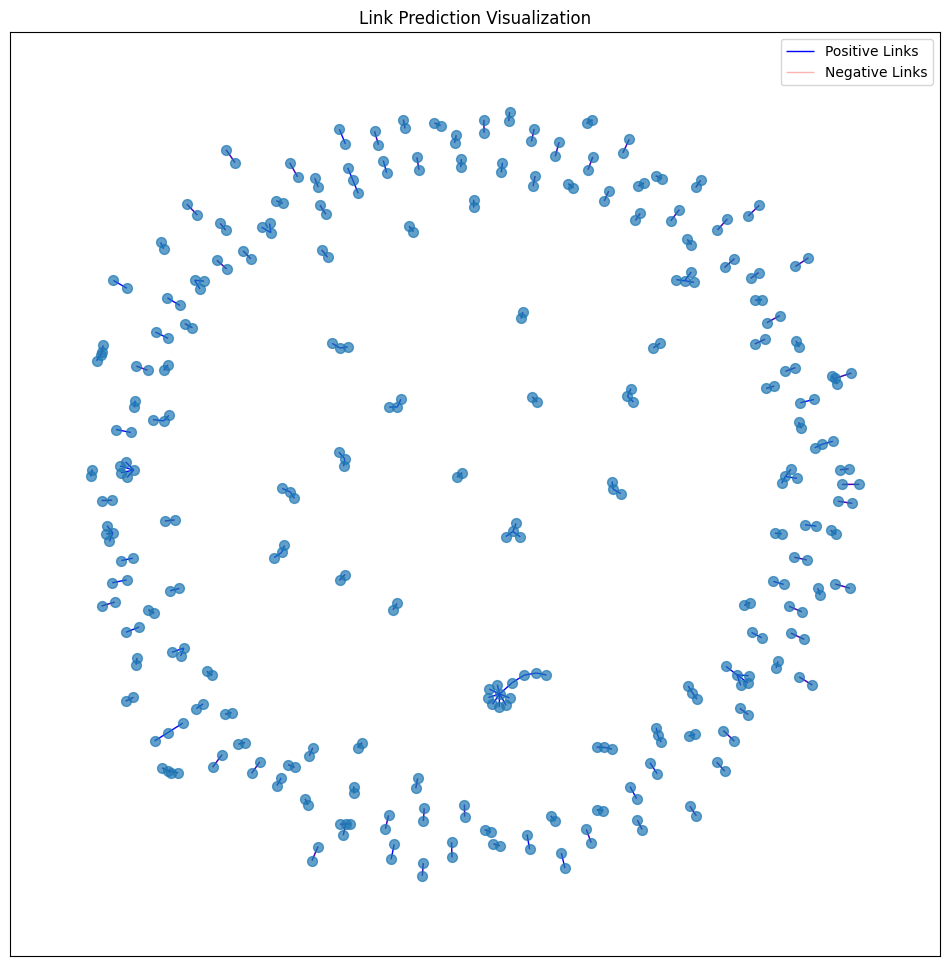

In [16]:
# Visualize a subset of the graph

subgraph = nx.Graph()
num_links = 100  # Adjust for visualization clarity
subgraph.add_edges_from(test_pos_edges[:num_links])  # Add positive edges
subgraph.add_edges_from(test_neg_edges[:num_links])  # Add predicted negative edges

pos = nx.spring_layout(subgraph)

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(subgraph, pos, node_size=50, alpha=0.7)
nx.draw_networkx_edges(subgraph, pos, edge_color="b", label="Positive Links")
nx.draw_networkx_edges(subgraph, pos, edgelist=test_neg_edges[:num_links], edge_color="r", alpha=0.3, label="Negative Links")
plt.title("Link Prediction Visualization")
plt.legend()
plt.show()
